# Counting Rings in Cropped Images - Real Data


Mod of [Zach Muller's WWF 01_Custom.ipynb](https://walkwithfastai.com/Custom).

Here we'll take cropped images of antinodes and try to count the rings.

> NOTE: IceVision will supply bounding boxes for cropping never-before-seen images.  That seems to work ok.  Putting this all together into one workflow is... the next thing. ;-) 

In [ ]:
#all_slow

In [ ]:
#hide
#Run once per session
!pip install fastai espiownage -q --upgrade
import espiownage
print(f"espiownage version {espiownage.__version__}")

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
espiownage version 0.0.35


And import our libraries

In [ ]:
from fastai.vision.all import *
from espiownage.core import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.data.external import untar_data, URLs

from fastai.data.block import RegressionBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())

1.9.0+cu111
True
1
0
GeForce RTX 3080


In [ ]:
path = Path('/home/shawley/datasets/espiownage-cleaner/crops') # real physics data is local and private

# cyclegan fake data is public, for demo & reproducibility:  add force_download=True to grab a new version if needed
#path = untar_data('http://hedges.belmont.edu/~shawley/espiownage-cyclegan.tgz') / 'crops'
print(path)

/home/shawley/datasets/espiownage-cleaner/crops


In [ ]:
fnames = get_image_files(path)
print(f"{len(fnames)} total cropped images")
ind = 1  # pick one cropped image
fnames[ind]

5219 total cropped images


Path('/home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_01083_156_232_247_339_1.8.png')

For labels, we want the ring count which is the number between the last '_' and the '.png'

In [ ]:
def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

1.8


In [ ]:
cropsize = (300,300) # pixels
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=label_func,
                   item_tfms=Resize(cropsize, ResizeMethod.Squish),
                   batch_tfms=[*aug_transforms(size=cropsize), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = croppedrings.dataloaders(path, bs=32)

/home/shawley/.local/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


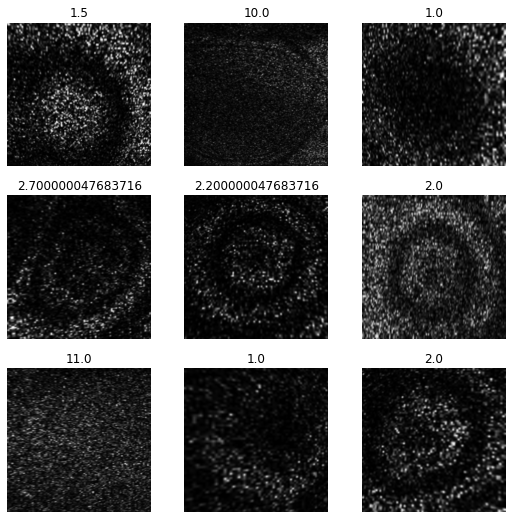

In [ ]:
dls.show_batch(max_n=9)

## Train model

In [ ]:
def acc_reg(inp, targ, bin_size=1): 
    "Accuracy for regression: Are we within +/- bin_size?"
    inp,targ = flatten_check(inp,targ) # https://docs.fast.ai/metrics.html#flatten_check
    where_correct = (inp-targ).abs() < bin_size
    return where_correct.float().mean() 

def acc_reg05(inp, targ): return acc_reg(inp, targ, bin_size=0.5)
def acc_reg1(inp, targ): return acc_reg(inp, targ, bin_size=1)
def acc_reg15(inp, targ): return acc_reg(inp, targ, bin_size=1.5)
def acc_reg2(inp, targ): return acc_reg(inp, targ, bin_size=2)

In [ ]:
opt = ranger

In [ ]:
#PETS example learner:learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=MSELossFlat(), n_out=1, y_range=(0,11), opt_func=opt)#.to_fp16()

y_range=(0.2,12)  # balance between "clamping" to range of real data vs too much "compression" from sigmoid nonlinearity
learn = cnn_learner(dls, resnet34, n_out=1, y_range=y_range, metrics=[mae, acc_reg05,acc_reg1,acc_reg15,acc_reg2], loss_func=MSELossFlat(), opt_func=opt)

SuggestedLRs(valley=0.004365158267319202)

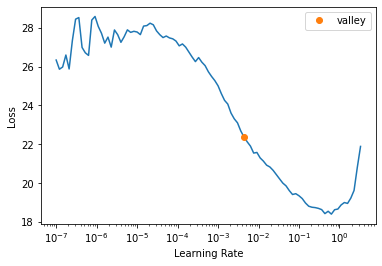

In [ ]:
learn.lr_find()

In [ ]:
#learn.fine_tune(10, 1e-2)
learn.fine_tune(20, 5e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,11.180530,8.719958,2.217401,0.098754,0.374880,0.504314,0.622244,00:16
1,8.957644,6.757199,1.928413,0.134228,0.410355,0.546501,0.676894,00:17


epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,6.290530,5.378365,1.692770,0.155321,0.446788,0.601151,0.741131,00:20
1,5.430495,3.574858,1.288535,0.274209,0.586769,0.723873,0.812081,00:20
2,3.947598,2.941916,1.146480,0.323106,0.622244,0.771812,0.842761,00:20
3,3.246834,3.281319,1.331887,0.243528,0.511026,0.662512,0.780441,00:20
4,2.662720,2.208718,0.940820,0.423778,0.715244,0.829338,0.891659,00:20
5,2.846100,2.389936,0.959706,0.436242,0.719080,0.825503,0.879195,00:20
6,2.325774,2.270345,0.932519,0.454458,0.714286,0.824545,0.886865,00:20
7,2.125805,1.865062,0.856778,0.474593,0.734420,0.858102,0.908917,00:20
8,2.059017,2.104184,0.922875,0.446788,0.712368,0.832215,0.897411,00:20
9,2.212233,2.080090,0.886241,0.495686,0.726750,0.836050,0.889741,00:20


In [ ]:
learn.save('crop-rings-real')

Path('models/crop-rings-real.pth')

## Interpretation

In [ ]:
learn.load('crop-rings-real');

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True) # validation set only
len(preds)

1043

I'll define a method to show a single prediction

In [ ]:
def showpred(ind, preds, targs, losses, dls): # show prediction at this index
    print(f"preds[{ind}] = {preds[ind]}, targs[{ind}] = {targs[ind]}, loss = {losses[ind]}")
    print(f"file = {dls.valid.items[ind]}")
    print("Image:")
    dls.valid.dataset[ind][0].show()

preds[0] = tensor([8.2935]), targs[0] = 9.0, loss = 0.49918004870414734
file = /home/shawley/datasets/espiownage-cleaner/crops/06240907_proc_01136_0_107_178_318_9.0.png
Image:


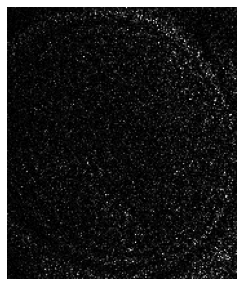

In [ ]:
showpred(0, preds, targs, losses, dls)

And now we'll run through predictions for the whole validation set:

In [ ]:
#preds, targs, losses = learn.get_preds(with_loss=True)
results = []
for i in range(len(preds)):
    line_list = [dls.valid.items[i].stem]+[round(targs[i].cpu().numpy().item(),2), round(preds[i][0].cpu().numpy().item(),2), losses[i].cpu().numpy(), i]
    results.append(line_list)

# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['filename', 'target', 'prediction', 'loss','i'])

We can do our own version of printing top_losses:

In [ ]:
res_df = res_df.sort_values('loss', ascending=False)
res_df.head()

,filename,target,prediction,loss,i
571,06241902_proc_00581_0_31_86_236_1.0,1.0,10.99,99.85656,571
1004,06241902_proc_00381_0_59_81_228_1.0,1.0,10.61,92.41923,1004
326,06241902_proc_00542_0_37_91_242_1.5,1.5,10.75,85.5445,326
118,06240907_proc_00322_0_114_195_323_2.2,2.2,8.94,45.363792,118
450,06240907_proc_01021_0_93_183_344_3.8,3.8,10.17,40.620274,450


preds[571] = tensor([10.9928]), targs[571] = 1.0, loss = 99.85655975341797
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00581_0_31_86_236_1.0.png
Image:
preds[1004] = tensor([10.6135]), targs[1004] = 1.0, loss = 92.41922760009766
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00381_0_59_81_228_1.0.png
Image:
preds[326] = tensor([10.7490]), targs[326] = 1.5, loss = 85.54450225830078
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00542_0_37_91_242_1.5.png
Image:
preds[118] = tensor([8.9353]), targs[118] = 2.200000047683716, loss = 45.363792419433594
file = /home/shawley/datasets/espiownage-cleaner/crops/06240907_proc_00322_0_114_195_323_2.2.png
Image:
preds[450] = tensor([10.1734]), targs[450] = 3.799999952316284, loss = 40.62027359008789
file = /home/shawley/datasets/espiownage-cleaner/crops/06240907_proc_01021_0_93_183_344_3.8.png
Image:


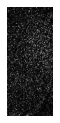

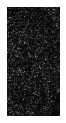

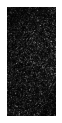

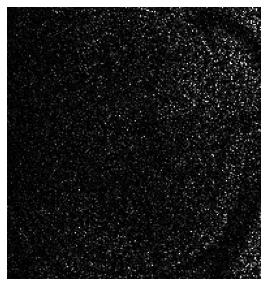

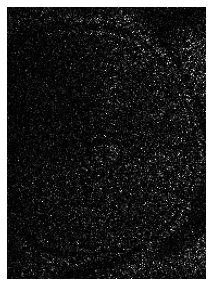

In [ ]:
def show_top_losses(res_df, preds, targs, losses, dls, n=5):
    for j in range(n):
        showpred(res_df.iloc[j]['i'], preds, targs, losses, dls)
        
show_top_losses(res_df, preds, targs, losses, dls)

So then we can these results output into a CSV file, and use it to direct our data-cleaning efforts, i.e. look at the top-loss images first! 

In [ ]:
res_df.to_csv('ring_count_top_losses_real.csv', index=False)

## When in doubt, LOOK AT THE DATA
Let's take a look at plots of this data

In [ ]:
df2 = res_df.reset_index(drop=True)

Text(0, 0.5, 'Ring count')

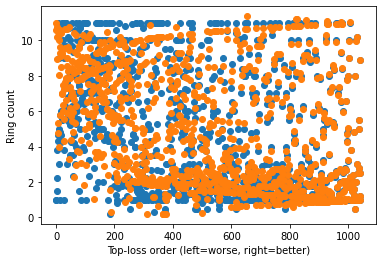

In [ ]:
plt.plot(df2["target"],'o')
plt.plot(df2["prediction"],'o')
plt.xlabel('Top-loss order (left=worse, right=better)')
plt.ylabel('Ring count')

(-0.34, 11.936, -0.35800000000000004, 11.918)

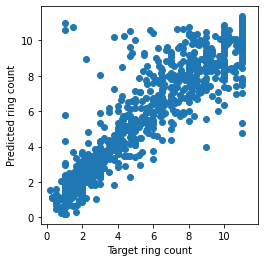

In [ ]:
plt.plot(df2["target"],df2["prediction"],'o')
plt.xlabel('Target ring count')
plt.ylabel('Predicted ring count')
plt.axis('square')

In [ ]:
print(f"Target ring count range: ({df2['target'].min()}, {df2['target'].max()})")
print(f"Predicted ring count range: ({df2['prediction'].min()}, {df2['prediction'].max()})")

Target ring count range: (0.2, 11.0)
Predicted ring count range: (0.2, 11.36)
